In [24]:
# Importing Libraries:

import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import lilliefors
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Importing data:

df_raw = pd.read_csv("KAG_energydata_complete.csv")

In [3]:
# Creating a copy of the dataset:

df = df_raw.copy()

In [4]:
# Looking at the first five lines: 

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## 1) Data Munging

#### 1.1) Data Cleaning

In [5]:
# Looking for missing data:

df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [6]:
# Setting column date as the dataframe's index:

df.set_index("date", inplace=True)

In [7]:
# Information about data types:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

#### 1.2) Exploratory Data Analisys

In [8]:
# Separating columns

temperature_column = [i for i in df.columns if "T" in i]
humidity_column = [i for i in df.columns if "RH" in i]
other = [i for i in df.columns if ("T" not in i)&("RH" not in i)]

In [9]:
# Humidity statistics:

df[humidity_column].describe()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


In [10]:
# Temperature statistics:

df[temperature_column].describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T_out,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665,3.760707
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409,4.194648
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000,-6.600000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667,0.900000
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667,3.433333
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333,6.566667
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000,15.500000


In [11]:
# Other column statistics:

df[other].describe()

,Appliances,lights,Press_mm_hg,Windspeed,Visibility,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,755.522602,4.039752,38.330834,24.988033,24.988033
std,102.524891,7.935988,7.399441,2.451221,11.794719,14.496634,14.496634
min,10.000000,0.000000,729.300000,0.000000,1.000000,0.005322,0.005322
25%,50.000000,0.000000,750.933333,2.000000,29.000000,12.497889,12.497889
50%,60.000000,0.000000,756.100000,3.666667,40.000000,24.897653,24.897653
75%,100.000000,0.000000,760.933333,5.500000,40.000000,37.583769,37.583769
max,1080.000000,70.000000,772.300000,14.000000,66.000000,49.996530,49.996530


Distributions

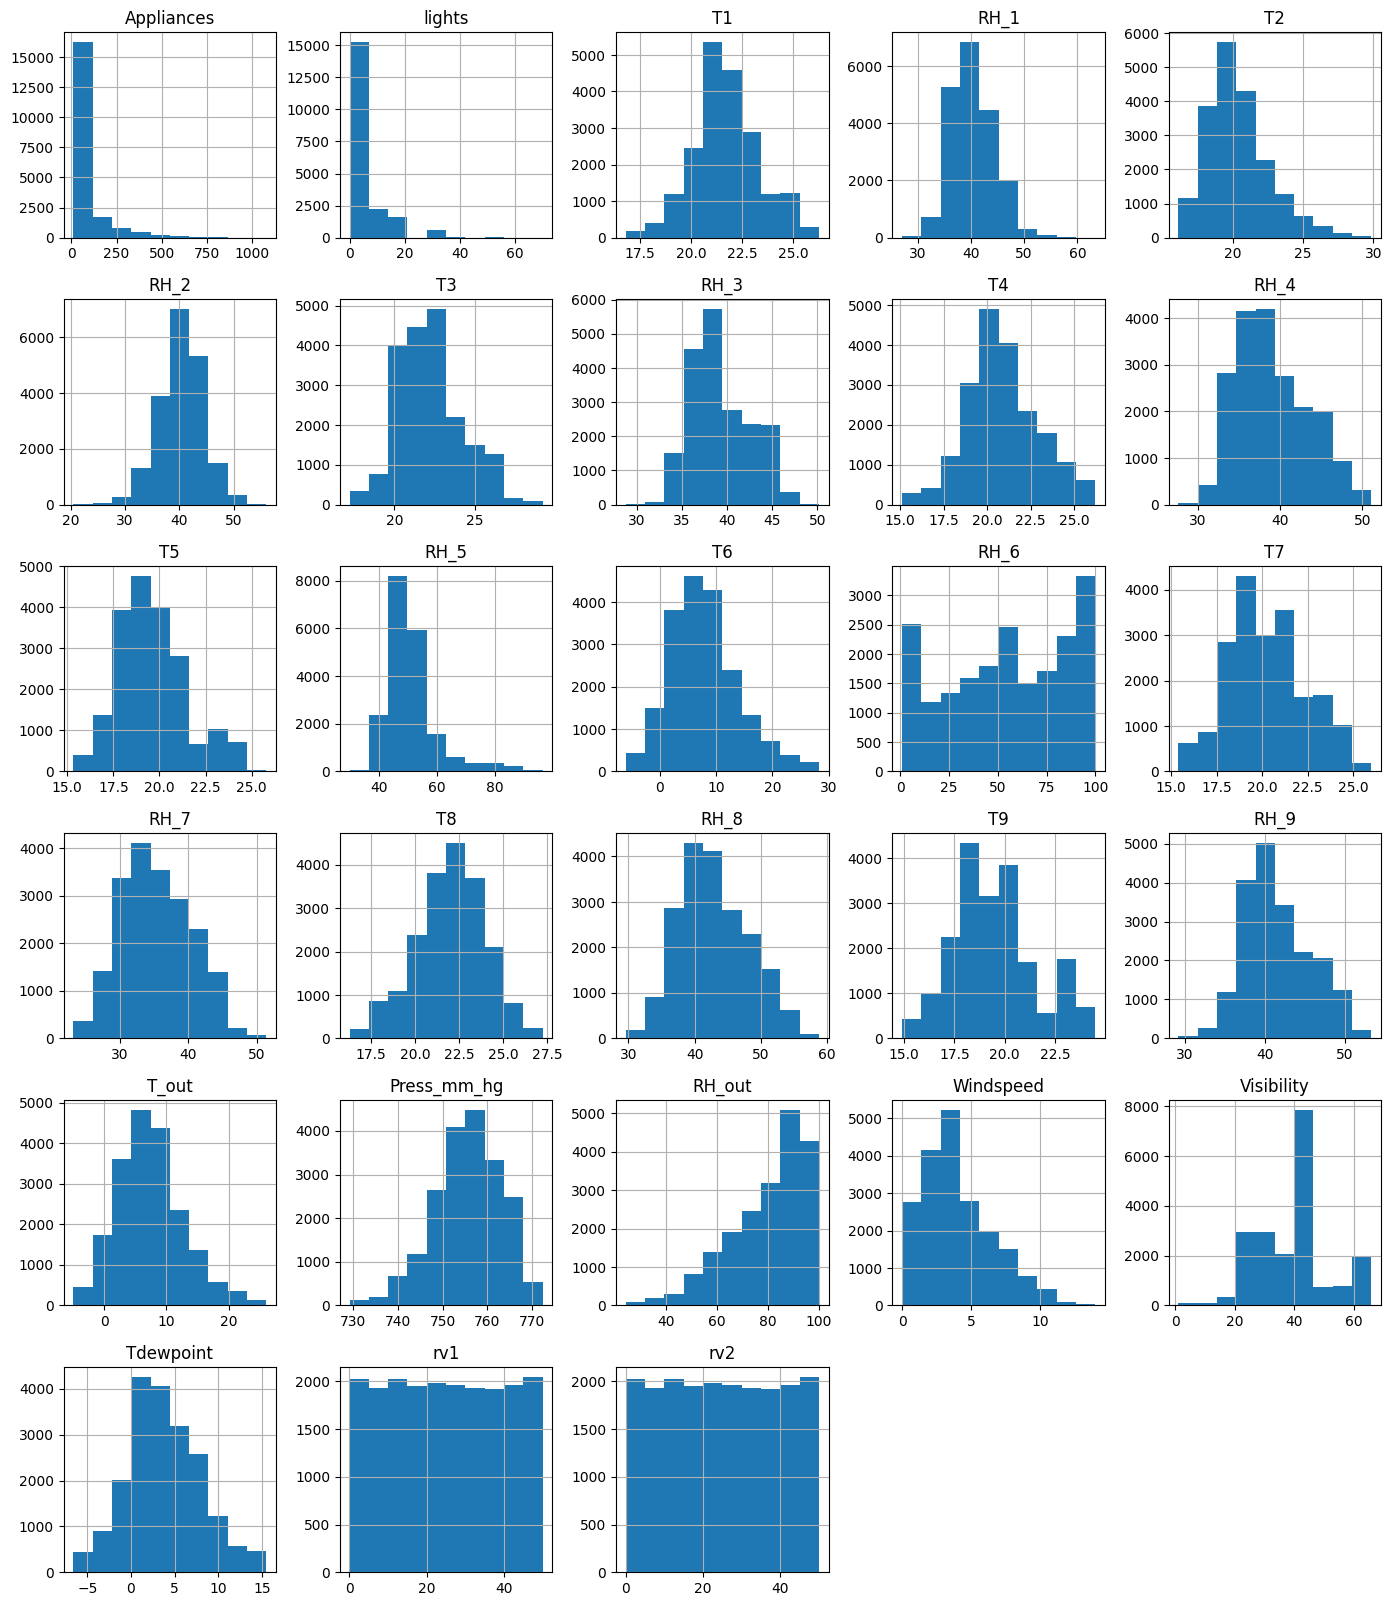

In [12]:
# Visualizing distributions using Histograms:

df.hist(figsize=(17, 20));

We will use a test statistic named Shapiro to evaluate normallity.

Obs:

1 - If p-value is smaller than 0.05, we can not assume a normal distribution.

2 - If p-value is larger than 0.05, we can assume a normal distribution.

3 - For datasets larger than 5000 samples, the p-value will be an approximation.

 

In [13]:
# Using Shapiro test for normallity evaluation:

for c in df.columns:
    w_statisc, p_values = shapiro(df[c])
    print(f'Test for {c}: (statistic={w_statisc}, p-value={p_values})')

Test for Appliances: (statistic=0.5764151811599731, p-value=0.0)
Test for lights: (statistic=0.5426443815231323, p-value=0.0)
Test for T1: (statistic=0.9914018511772156, p-value=2.131765323498354e-32)
Test for RH_1: (statistic=0.9837190508842468, p-value=5.145567961000728e-42)
Test for T2: (statistic=0.9549049139022827, p-value=0.0)
Test for RH_2: (statistic=0.9937852621078491, p-value=5.234702144451298e-28)
Test for T3: (statistic=0.9819837212562561, p-value=1.1630777253895982e-43)
Test for RH_3: (statistic=0.9622328877449036, p-value=0.0)
Test for T4: (statistic=0.9893089532852173, p-value=1.561547817796443e-35)
Test for RH_4: (statistic=0.9690612554550171, p-value=0.0)
Test for T5: (statistic=0.9709550738334656, p-value=0.0)
Test for RH_5: (statistic=0.8415567278862, p-value=0.0)
Test for T6: (statistic=0.9769178628921509, p-value=0.0)
Test for RH_6: (statistic=0.9380175471305847, p-value=0.0)
Test for T7: (statistic=0.9852830171585083, p-value=2.0875843872278962e-40)
Test for RH_7:

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Correlations

We will use Pearson's correlarion due to the type and nature of the variables (numeric target and features)

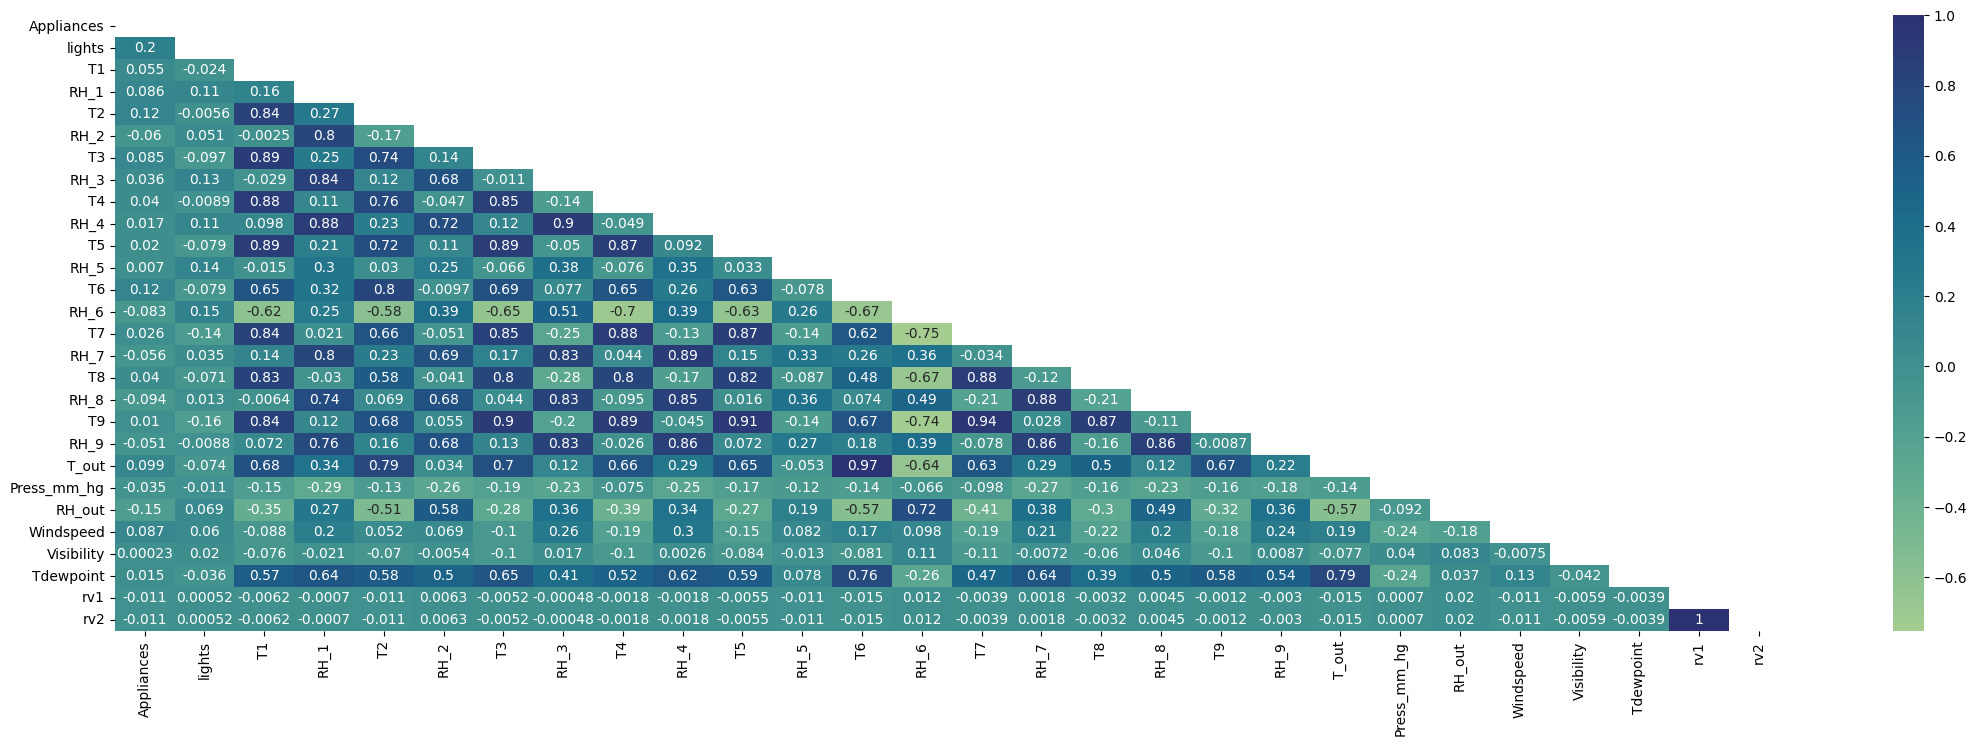

In [39]:
# Plotting a Heatmap with all the correlations:

correlations=df.corr()

mask =  np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(27, 8))
sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");

In [ ]:
# Let's separate the target from the whole dataset:

target = df["Appliances"]
features = df.drop(columns='Appliances')